In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import imageio
from PIL import Image
from datetime import datetime
from tqdm import tqdm

from IPython.display import display, clear_output
import time

# Define classes

In [50]:
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1.0)
#         nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
#     classname = m.__class__.__name__
#     if classname.find('Linear') != -1:
#         m.weight.data.normal_(0.0, 1.0)
#         if m.bias is not None:
#             m.bias.data.fill_(0)

class Rule(nn.Module):
    def __init__(self, dim_in, dim_z, dim_c):
        super().__init__()
        
        self.in_l = [nn.Linear(1, net_size[0], bias=False).cuda() for i in range(dim_in - 1)]
        self.in_l.append(nn.Linear(dim_z, net_size[0], bias=False).cuda())
        self.in_l = nn.ModuleList(self.in_l)
        
        self.seq = []
        self.seq.append(nn.Tanh())
        for i in range(len(net_size) - 1):
            self.seq.append((nn.Linear(net_size[i], net_size[i + 1])))
            self.seq.append(nn.Tanh())
            
#             self.seq.append(nn.Conv2d(net_size[i], net_size[i + 1], 3, padding=1, padding_mode='reflect'))
#             self.seq.append(nn.ReLU())
        
        self.seq.append(nn.Linear(net_size[-1], dim_c))
        self.seq.append(nn.Sigmoid())
        
        self.seq = nn.ModuleList(self.seq)

            
class CPPN(nn.Module):
    def __init__(self, net_size= [32, 32, 32], dim_z=16, dim_c=3, scale=5, res=512):
        super().__init__()
        
        self.dim_c = dim_c
        self.init_grid(scale, res)  # init self.coords
        
        self.dim_in = len(self.coords)
#         self.ls_coords = [nn.Linear(1, net_size[0], bias=False).cuda() for i in range(self.dim_in - 1)]
#         self.ls_coords.append(nn.Linear(dim_z, net_size[0], bias=False).cuda())  # the layer for the latent-vector z
        
#         modules = []
#         modules.append(nn.Tanh())
#         for i in range(len(net_size) - 1):
#             modules.append(nn.Linear(net_size[i], net_size[i + 1]))
#             modules.append(nn.Tanh())
            
#         modules.append(nn.Linear(net_size[-1], dim_c))
#         modules.append(nn.Sigmoid())

        self.rule = Rule(self.dim_in, dim_z, self.dim_c)
#         self.ls_coords = self.rule.in
#         self.seq = nn.Sequential(*self.rule.seq)

#         self.seq = nn.Sequential(*modules)
#         self.modules = nn.ModuleList((self.ls_coords + modules))
        
        self.apply(weights_init)
        
    def _coordinates(self, scale, xres, yres, z, flatten=True, batch_size=1):
        
        # check if z has the same batch dim as batch_size
        if z.shape[0] != batch_size:
            print('z.shape[0] != batch_size. Doing nothing.')
            pass
        
        z = z.unsqueeze(1)
        
        # generate X, Y, R coordinate grid
        aspect_ratio = xres / yres
        xv = np.linspace(-scale, scale, xres) * aspect_ratio
        yv = np.linspace(-scale, scale, yres)
        X, Y = np.meshgrid(xv, yv)
        R = np.sqrt(X**2 + Y**2)             
        
        # only kept unflattened for hires images 
        if flatten:
            X, Y, R = X.reshape(1, -1, 1), Y.reshape(1, -1, 1), R.reshape(1, -1, 1) # shape=(batch_size, *, in_features)
        
        # tile for batch size
        X, Y, R = np.tile(X, (batch_size, 1, 1)), np.tile(Y, (batch_size, 1, 1)), np.tile(R, (batch_size, 1, 1))

        return [X, Y, R, z]
    
    def init_grid(self, scale, res, z=None):
        if z is None:
            z = torch.zeros(dim_z)
        self.coords = [coord for coord in self._coordinates(scale, res, res, z)]
    
    def reinit(self, empty_cache=False):
        
        if empty_cache:
            torch.cuda.empty_cache()
            
        self.apply(weights_init)
    
    def forward(self, coords, xres, yres):
        
        if coords is None:
            coords = self.coords
        U = [self.rule.in_l[i](torch.cuda.FloatTensor(coord)) for i, coord in enumerate(coords)]

        U = sum(U)
        
        # linear layers
        out = nn.Sequential(*self.rule.seq)(U)

        # if using convs
#         U = U.permute(0, 2, 1).reshape(U.shape[0], -1, yres, xres)
#         out = nn.Sequential(*self.rule.seq[:-2])(U)
#         out = out.permute(0, 2, 3, 1).reshape(out.shape[0], -1, out.shape[1])
#         out = nn.Sequential(*self.rule.seq[-2:])(out)
        
        return out
    
class Sampler():
    def __init__(self, res=512, scale=5):
        self.res = res
        self.scale = scale

    
    def generate_img(self, cppn, z, scale=None, res=None, coords=None):
        
        with torch.no_grad():
            if scale is None:
                scale = self.scale
            if res is None:
                res = self.res
            if coords is None:
                coords = cppn._coordinates(scale, res, res, z)

            out = cppn.forward(coords, res, res).cpu().numpy()

        return out.reshape(res, res, -1)
    
    def imshow(self, x):
        
        img = x
            
        dim_c = img.shape[2]
    
        fig, ax = plt.subplots(figsize=(9, 16))

        if dim_c == 1:
            img = img[:, :, 0]
            ax.imshow(img, cmap='Greys')
        else:        
            ax.imshow(img)
        ax.set_axis_off()
        plt.show()
    
    def generate_hires(self, cppn, z, scale=None, x_dim=256, y_dim=256, x_reps=16, y_reps=9, coords=None):
        
        if scale is None:
            scale = self.scale

        x_dim_big = x_dim*x_reps
        y_dim_big = y_dim*y_reps
        
        with torch.no_grad():
            if coords is None:
                coords = cppn._coordinates(scale, x_dim_big, y_dim_big, z, flatten=False)
                
            # just expect all input coords to be non-flattened
#             else:
#                 coords = [coord.reshape(-1, y_dim_big, x_dim_big) for coord in coords]

            z = coords[-1]
            coords = coords[:-1]

            out = np.zeros((y_dim_big, x_dim_big, cppn.dim_c))
            for ix in tqdm(range(x_reps)):
                x_start = ix * x_dim
                x_end = x_start + x_dim

                for iy in range(y_reps):
                    y_start = iy * y_dim
                    y_end = y_start + y_dim

                    coords_small = [coord[:, y_start:y_end, x_start:x_end].reshape(1, -1, 1) for coord in coords]
                    coords_small.append(z)
                    img_section = cppn.forward(coords_small, x_dim, y_dim).reshape(y_dim, x_dim, cppn.dim_c)

                    out[y_start:y_end, x_start:x_end, :] = img_section.cpu().numpy()
                
        return out
    
        

In [51]:
# net_size = [1024, 32, 256, 16, 128, 6, 6, 6]
net_size = [512, 32, 256, 16, 128, 6, 6, 6]
# net_size = [128, 128, 64, 64, 32, 32]
# net_size = np.tile([256, 16, 8], 2)
dim_z = 16
dim_c = 3
print(net_size)

cppn = CPPN(net_size, dim_z, dim_c).cuda()
sampler = Sampler(cppn)

[512, 32, 256, 16, 128, 6, 6, 6]
z.shape[0] != batch_size. Doing nothing.


# Generate Image

### Standard res.

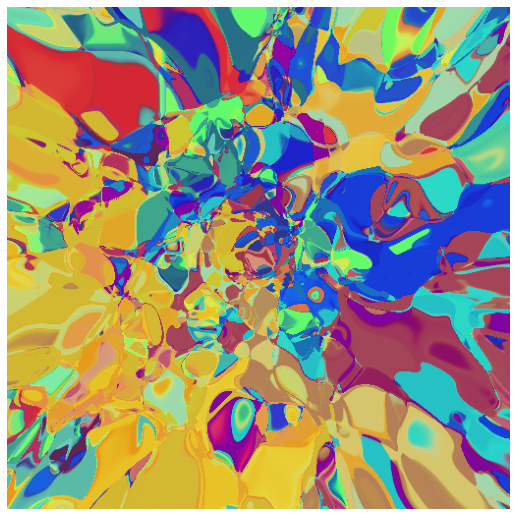

In [53]:
cppn.reinit(empty_cache=True)
scale = 10
res = 512
zscale = 2

z = torch.randn(1, dim_z).cuda()
# z2 = z + 0.*torch.randn(1, dim_z).cuda()
coords = cppn._coordinates(scale, res, res, z*zscale)
# coords[0] = coords[0] * np.sin(5*coords[0])
# coords[1] = coords[1] * np.sin(5*coords[1])
# coords[0] = x[:, :, 0].reshape(-1, 1)
# coords[1] = x[:, :, 1].reshape(-1, 1)
# coords[2] = x[:, :, 2].reshape(-1, 1)
# coords[3] = coords[3].cpu().numpy() * (1 + 1/coords[2])

# coords = [x[:, :, 0].reshape(-1, 1)].append(z)
x = sampler.generate_img(cppn, z*zscale, scale, res, coords=coords)
sampler.imshow(x)

### Hires

100%|██████████| 10/10 [00:01<00:00,  9.00it/s]


(5120, 5120, 3)


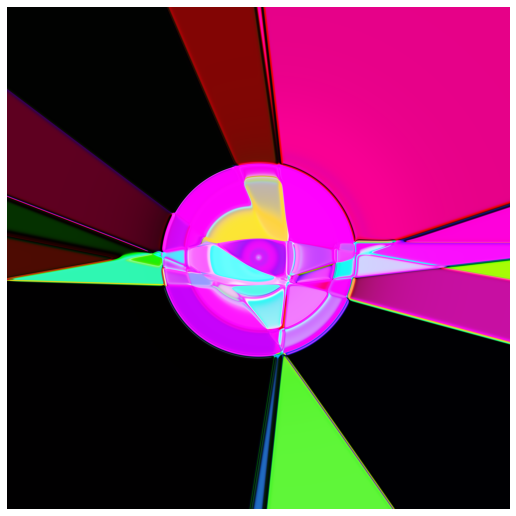

In [847]:
# coords = cppn._coordinates(scale, 256*16, 256*16, z*zscale, flatten=False)
# coords[0] = coords[0] + np.cos(coords[0]/2)
# coords[1] = coords[1] + np.sin(coords[1]/2)
# coords[3] = coords[3].cpu().numpy() * (1 + 1/coords[2])

x = sampler.generate_hires(cppn, z=z*zscale, scale=scale, x_dim=512, y_dim=512, x_reps=10, y_reps=10)
print(x.shape)
sampler.imshow(x)
  
time_str = datetime.now().strftime("%y-%m-%d-%H-%M-%S.%f")
figname = 'cppn/hi_res/' + time_str + '.png'
imageio.imwrite(figname, (x * 255).astype(np.uint8), format='png')

# Train

In [7]:
MSELoss = nn.MSELoss()

In [8]:
target_file = 'cppn/target/flower.jpg'
img = Image.open(target_file)


In [28]:
EPOCHS = 20000
XRES=128
YRES=128
BATCH_SIZE=30

MASK_INDEX = 0

TARGET = np.array(img.resize((XRES, YRES), Image.ANTIALIAS))
mask = torch.cuda.FloatTensor(TARGET[:, :, MASK_INDEX] > 5).reshape(-1)
mask = mask.unsqueeze(0).unsqueeze(-1)

TARGET = TARGET[:, :, :3].reshape(1, -1, 3).astype('float64')
TARGET = TARGET/TARGET.max()
TARGET = torch.cuda.FloatTensor(np.tile(TARGET, (BATCH_SIZE, 1, 1)))



scale_in = scale
zscale = zscale
# z = torch.randn(BATCH_SIZE, dim_z).cuda()
z_in = zscale * z.repeat(BATCH_SIZE, 1)

optim = torch.optim.Adam(cppn.parameters(), lr=1e-3)
lambda1 = lambda epoch: 1 / (1 + epoch // 1000)
scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lambda1)
need_new_grid = True
# losses = []

for epoch in range(EPOCHS):
    optim.zero_grad()
    
#     z_in = zscale * torch.randn(BATCH_SIZE, dim_z).cuda()
    
    delta_z = 0.1*torch.randn(BATCH_SIZE, dim_z).cuda()
    zt = z_in + delta_z

    if need_new_grid:
        x = cppn._coordinates(scale_in, xres=XRES, yres=YRES, z=zt, batch_size=BATCH_SIZE)
        need_new_grid = False
    else:
        x = x[:-1]
        x.append(zt.unsqueeze(1))  # remove z layer inputs and replace with new z
    out = cppn.forward(x, XRES, YRES)
    
    
    out_masked = out * mask
    TARGET = TARGET * mask
    loss = MSELoss(out.mean(2), TARGET.mean(2))
    loss.backward()
    optim.step()
    scheduler.step()
    
    losses.append(loss.item())
    
    
    if epoch % 30 == 0:
        alpha = 0.5
        nx = out[0].detach().cpu().numpy().reshape(YRES, XRES, -1)
        s_losses = alpha * np.array(losses[:-1]) + (1 - alpha) * np.array(losses[1:])

        plt.clf()
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(nx)
        ax[1].plot(np.log10(s_losses))
        ax[1].scatter(np.arange(len(losses)), np.log10(losses), s=2)
        plt.gcf().set_size_inches((16,8))
        clear_output(wait=True)
        print(f'{epoch}')
        display(plt.gcf())
        time.sleep(0.01)
        plt.close()
        
    if epoch % 1000 == 0 and epoch != 0:
        XRES += 4
        YRES += 4
        need_new_grid = True
        
        TARGET = np.array(img.resize((XRES, YRES), Image.ANTIALIAS))        
        mask = torch.cuda.FloatTensor(TARGET[:, :, MASK_INDEX] > 1e-5).reshape(-1)
        mask = mask.unsqueeze(0).unsqueeze(-1)
        
        TARGET = TARGET[:, :, :3].reshape(1, -1, 3).astype('float64')
        TARGET = TARGET/TARGET.max()
        TARGET = torch.cuda.FloatTensor(np.tile(TARGET, (BATCH_SIZE, 1, 1)))
        
    
    

RuntimeError: CUDA out of memory. Tried to allocate 960.00 MiB (GPU 0; 10.73 GiB total capacity; 7.70 GiB already allocated; 494.44 MiB free; 8.52 GiB reserved in total by PyTorch)

# Output weights

In [44]:
test = [p for p in cppn.state_dict()]
test

['rule.in_l.0.weight',
 'rule.in_l.1.weight',
 'rule.in_l.2.weight',
 'rule.in_l.3.weight',
 'rule.seq.1.weight',
 'rule.seq.1.bias',
 'rule.seq.3.weight',
 'rule.seq.3.bias',
 'rule.seq.5.weight',
 'rule.seq.5.bias',
 'rule.seq.7.weight',
 'rule.seq.7.bias']

In [56]:
theObject = cppn
for property, value in vars(theObject).items():
    print(property, ":", value)

training : True
_parameters : OrderedDict()
_buffers : OrderedDict()
_backward_hooks : OrderedDict()
_forward_hooks : OrderedDict()
_forward_pre_hooks : OrderedDict()
_state_dict_hooks : OrderedDict()
_load_state_dict_pre_hooks : OrderedDict()
_modules : OrderedDict([('rule', Rule(
  (in_l): ModuleList(
    (0): Linear(in_features=1, out_features=256, bias=False)
    (1): Linear(in_features=1, out_features=256, bias=False)
    (2): Linear(in_features=1, out_features=256, bias=False)
    (3): Linear(in_features=16, out_features=256, bias=False)
  )
  (seq): ModuleList(
    (0): Tanh()
    (1): Linear(in_features=256, out_features=32, bias=True)
    (2): Tanh()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): Tanh()
    (5): Linear(in_features=32, out_features=3, bias=True)
    (6): Tanh()
    (7): Linear(in_features=3, out_features=3, bias=True)
    (8): Sigmoid()
  )
))])
dim_c : 3
coords : [array([[-5.        ],
       [-4.98043053],
       [-4.96086106],
       ..

In [ ]:
grouped = []

model_seq = cppn.seq

for seq in model_seq:
    if seq.__class__.__name__ == 'Linear':

In [ ]:
num_input_layers = 8  ## 1 for z, 3 for coordinates, 4 for extra functions. These layers have no biases
evaled = [var.eval(session=sampler.cppn.sess) for var in tf.get_default_graph().get_collection('trainable_variables')]

def tanh_activation(x):
    x = tf.nn.tanh(x)
    
    return x

def sigmoid_activation(x):
    x = tf.nn.signmoid
    
    return x 

grouped = []
pos_list = np.concatenate((np.arange(0, num_input_layers), np.arange(num_input_layers, len(evaled), 2)))
for pos in pos_list:
    
    if pos != len(evaled):
        activation_fn = tanh_activation
    else:
        activation_fn = sigmoid_activation
    
    if pos >= num_input_layers and pos < (len(evaled) - 1):
        bias = evaled[pos+1][0,:]
    else:
        bias = np.array(0)
    
    shape = evaled[pos].shape
    evaled[pos] = evaled[pos] * np.sqrt(6 / (shape[0] + shape[1]))  # doing the xavier weights externally cuz the fucking tensorflow variable wont update
        
    grouped.append({'weights': evaled[pos], 
                   'bias': bias,
                    'activation': activation_fn
                   })
